In [47]:
from collections import Counter, defaultdict
from functools import partial, reduce
from scipy.stats import pearsonr,tstd
import math, random, csv
import matplotlib.pyplot as plt
import dateutil.parser

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['normal', 'f', 'random', 'uniform']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


10.1 데이터 탐색

해결 문제를 파악 후 관련 데이터를 받았다면, 데이터 탐색이 가장 우선적으로 되어야 한다.

10.1.1 1차원 데이터 탐색

가장 간단한 경우는 단순 숫자로 이뤄진 1차원 데이터. 

(e.g. 사용자가 하루 평균 사이트에서 보내는 시간, 데이터 과학 관련 튜토리얼 비디오가 재생된 횟수, 데이터 과학 책 쪽수)

가장 먼저 요약통계치(summary statistics) 계산

즉, 데이터의 최소, 최대, 평균, 표준편차값에 대해 알아보아야 한다.

하지만, 요약통계치가 무의미한 경우도 있는데, 이럴 경우, 범위를 몇 개의 구간으로 나눈 뒤, 각 구간 내 데이터 개수를 살펴보는 히스토그램(histogram)을 만든다.

In [13]:
def normal_cdf(x, mu=0,sigma=1):
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001): #tolerance = 공차 #모든 수가 같은 비중을 둔다는 의미.
    # 이진검색을 통해서 역함수 근사

    # 표준정규분포가 아니면 표준정규분포로 변환()
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)
    
    #수평축 값의 범위가 -10 ~ 10
    low_z, low_p = -10.0, 0            # normal_cdf(-10) is (very close to) 0
    hi_z,  hi_p  =  10.0, 1            # normal_cdf(10)  is (very close to) 1

    #표준정규분포의 구간을 반복적으로 이등분하되, 원하는 확률값에 가까워질 때까지 계속 나눈다(hi_z - low_z =< tolerance일 때까지)
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the cdf's value there
        if mid_p < p:
            # midpoint is still too low, search above it
            low_z, low_p = mid_z, mid_p
        elif mid_p > p:
            # midpoint is still too high, search below it
            hi_z, hi_p = mid_z, mid_p
        else:
            break

    return mid_z

In [14]:
def bucketize(point, bucket_size):
    # 각 데ㅣ터를 bucket_size의 배수에 해당하는 구간에 위치
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points, bucket_size):
    # 구간 생성, 각 구간 내 데이터 개수 계산
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points, bucket_size, title = ""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width = bucket_size)
    plt.title(title)
    plt.show()
    
random.seed(0)

# -100과 100 사이의 균등분포
uniform = [200 * random.random() - 100 for _ in range(10000)]

# 평균이 0이고 표준편차가 57인 정규분포
normal = [57 * inverse_normal_cdf(random.random())
         for _ in range(10000)]

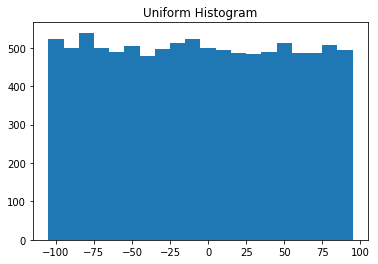

In [15]:
plot_histogram(uniform, 10, "Uniform Histogram")

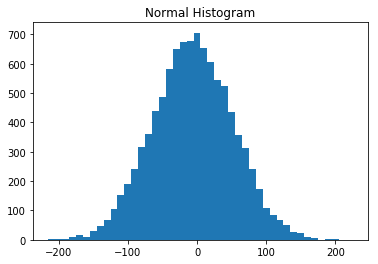

In [16]:
plot_histogram(normal, 10, "Normal Histogram")

# 두 분포의 최대, 최소값이 상당히 다르지만, 이것만으로는 두 분포의 차이를 이해하지 쉽지 x

10.1.2 2차원 데이터

2차원 데이터가 주어졌다고 가정.

e.g. 사용자가 하루 평균 사이트에서 보내는 시간 뿐 아니라 사용자의 데이터 과학 경력까지 주어졌다고 가정.

두 변수가 2차원 공간상에서 어떻게 분포를 이루는지 살펴보는 것도 의미가 있다.

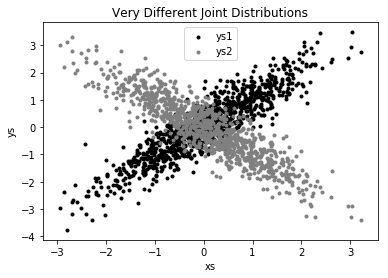

In [17]:
def random_normal():
    # 표준정규분포를 따르는 임의의 데이터 반환
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)]

ys1 = [x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

plt.scatter(xs, ys1, marker = '.', color = 'black', label = 'ys1')
plt.scatter(xs, ys2, marker = '.', color = 'gray', label = 'ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc = 9)
plt.title("Very Different Joint Distributions")
plt.show()

In [18]:
# 상관관계 차이
print(pearsonr(xs,ys1))
print(pearsonr(xs,ys1)[0])
print(pearsonr(xs,ys2))
print(pearsonr(xs,ys2)[0])

(0.9056623588363758, 0.0)
0.9056623588363758
(-0.8958327714107468, 0.0)
-0.8958327714107468


10.1.3 다차원 데이터

다차원 데이터의 경우 각 차원이 서로 어떤 연관인지 볼 수 있음.

가장 간단한 방법은 상관관계 행렬.

상관관계 행렬의 i번째 행과 j번째 열에 해당하는 값은 i번째 차원과 j번째 차원의 상관관계를 나타냄

In [19]:
def corrlation_matrix(data):
    # (i,j)번째 항목이 i번째 차원과 j번째 차원의 상관관계를 나타내는 
    # num_columns X num_columns 행렬 반환
    _, num_columns = shape(data)
    
    def matrix_entry(i,j):
        return pearsonr(get_column(data, i), get_column(data,j))
    
    return make_matrix(num_columns, num_columns, matrix_entry)

In [20]:
def get_column(A, j):
    return [A_i[j]         # A_i 행의 j번째 원소
            for A_i in A]  # 각 A_i 행에 대해

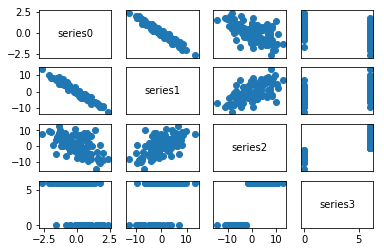

In [21]:
import matplotlib.pyplot as plt

num_points = 100

def random_row():
    row = [None, None, None, None]
    row[0] = random_normal()
    row[1] = -5 * row[0] + random_normal()
    row[2] = row[0] + row[1] + 5 * random_normal()
    row[3] = 6 if row[2] > -2 else 0
    
    return row

random.seed(0)
data = [random_row() for _ in range(num_points)]

_, num_columns  = shape(data)
fig, ax = plt.subplots(num_columns, num_columns)

for i in range(num_columns):
    for j in range(num_columns):
        
        # x축은 j번째 열을, y축은 i번째 행을 나타내는 산포도
        if i != j:
            ax[i][j].scatter(get_column(data, j), get_column(data, i))

        # 만약 i == j, series 라는 제목 출력
        else:
            ax[i][j].annotate("series" + str(i), (0.5,0.5),
                             xycoords = 'axes fraction',
                             ha = 'center', va = 'center')

        # 왼쪽과 밑에 위치한 차트만 축 레이블 명시
        if i < num_columns -1 : 
            ax[i][j].xaxis.set_visible(False)
        if j > 0:
            ax[i][j].yaxis.set_visible(False)

# 밑에서 가장 오른쪽 그리고 왼쪽에서
# 가장 위에 위치한 차트 안에는 문자열만 있기 떄문
# 축 레이블 고정
ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())

plt.show()

series 1은 series 0과 음의 상관관계.

series 2는 series 1과 양의 상관관계.

series 3은 0,6 두 가지 값만 가짐. 그 중, series의 작은 값들에 대응하며 6은 series 2의 큰 값들에 대응

이 방법을 사용하면 주어진 변수끼리 대략 어떤 관계를 가지는지 간편하게 살펴볼 수 있음.

10.2 정제하고 합치기

보통 데이터를 사용하기 전 정제하는 과정이 필요.

데이터를 정제할 때, csv.reader를 치환하는 함수를 만들어서 데이터를 파싱하는 것이 안전하다.

각 열의 파싱 방법을 명시하고 있는 파서를 list 형태로 함수로 넣는다.

이 때, None은 '이 열은 전처리를 하지 말자'는 의미.

In [22]:
def parse_row(input_row, parsers):
    # 파서 list(None이 포함될 수도 있음.)가 주어지면
    # 각 input_row의 항목을 적절한 파서를 적용
    
    return [parser(value) if parser is not None else value
            for value, parser in zip(input_row, parsers)]

def parse_rows_with(reader, parsers):
    # 각 열에 파서를 적용하기 위해 reader를 치환
    for row in reader:
        yield parse_row(row, parsers)

만약 '나쁜' 데이터가 포함되어있다면 (e.g. 데이터에 숫자가 아닌 float형 일 때) 코드가 오류로 인한 종료보다는 None으로 파싱되는것이 나음.

In [23]:
def try_or_none(f):
    # f가 하나의 입력값을 받는다고 가정,
    # 오류가 발생하면 f는 None을 반환해주는 함수로 치환
    def f_or_none(x):
        try:
            return f(x)
        except:
            return None
    return f_or_none

그리고 다음과 같이 parse_row 함수를 수정

In [24]:
def parse_row(input_row, parsers):
    return [try_or_none(parser)(value) if parser is not None else value
            for value, parser in zip(input_row, parsers)]

가령 쉼표로 구분된 주가 데이터에 다음과 같이 나쁜 데이터가 포함되어 있다고 가정.

6/20/2014,AAPL,90.91

6/20/2014,MSFT,41.68

6/20/3014,FB,64.5

6/19/2014,AAPL,91.86

6/19/2014,MSFT,n/a

6/19/2014,FB,64.34

In [25]:
import dateutil.parser
data = []

with open("comma_delimited_stock_prices.csv", "rt") as f:
    reader = csv.reader(f)
    
    for line in parse_rows_with(reader, [dateutil.parser.parse, None, float]):
        data.append(line)

그리고 data에서 None인 행만 살펴보고 어떻게 할지 결정만 하면 됨.

In [26]:
for row in data:
    if any(x is None for x in row):
        print(row)

[datetime.datetime(2014, 6, 20, 0, 0), 'AAPL', 90.91]
[datetime.datetime(2014, 6, 20, 0, 0), 'MSFT', 41.68]
[datetime.datetime(3014, 6, 20, 0, 0), 'FB', 64.5]
[datetime.datetime(2014, 6, 19, 0, 0), 'AAPL', 91.86]
[datetime.datetime(2014, 6, 19, 0, 0), 'MSFT', None]
[datetime.datetime(2014, 6, 19, 0, 0), 'FB', 64.34]


나쁜 데이터를 처리하는 방법
    1. 직접 제거
    2. 직접 수정
    3. 없기를 기도...

또한, csv.DictReader에 대해서도 비슷한 헬퍼 함수를 만들 수 있음. 이런 경우 dict형태의 파서 목록과 파서의 필드이름을 같이 제공해야함.

In [27]:
def try_parse_field(field_name, value, parser_dict):
    # parse_dict에 포함되어 있는 파서 중 하나로 파싱
    parser = parser_dict.get(field_name) # 만약 필드 이름이 존재하지 않으면 None 반환
    
    if parser is not None:
        return try_or_none(parser)(value)
    else:
        return value

def parse_dict(input_dict, parser_dict):
    return {field_name : try_parse_field(field_name, value, parser_dict)
            for field_name, value in input_dict.items()}

데이터 정제가 끝나면, 데이터에 이상치가 있는지 확인해야 함.

10.3 데이터 처리

데이터 처리는 가장 중요한 기술 중 하나.

In [28]:
# data = [
#     {'closing_price' : 102.06,
#     'date' : datetime.datetime(2014, 8, 29, 0, 0),
#     'symbol' : 'AAPL'}
#     # ...
# ]

예를 들어 위와 같이 dict 형태로 이뤄진 주가 데이터가 있다고 가정한다면,

데이터를 살펴보면 더 간편하게 데이터를 처리할 수 있는 패턴을 찾을 수 있음.

e.g. AAPL 종가의 최고치를 다음과 같은 단계로 찾아 볼 수 있다.
    1. 살펴볼 데이터를 AAPL에 대한 행으로 한정.
    2. 각 행에서 closing_price를 갖고 온다.
    3. closing_price의 max를 찾는다.
   
이 모든 것을 list comprehension으로 처리 가능.

In [29]:
with open("stocks.txt", "r", encoding='utf8', newline='') as f:
    reader = csv.DictReader(f, delimiter="\t")
    data = [parse_dict(row, {'date' : dateutil.parser.parse,
                             'closing_price' : float })
                for row in reader]
    
max_appl_price = max(row["closing_price"]
                     for row in data
                     if row["symbol"] == "AAPL")
max_appl_price

119.0

데이터 전체를 활용한다면 다음과 같이 모든 주식의 최고 종가를 찾아 볼 수도 있다.
    1. symbol이 동일한 모든 행을 하나의 그룹으로 모은다.
    2. 위와 동일한 과정으로 각 그룸의 최고치를 찾는다.


In [30]:
# symbol을 기준으로 행을 그룹화
by_symbol = defaultdict(list)
for row in data:
    by_symbol[row["symbol"]].append(row)

print("by_symbol: ", by_symbol)
    
    
# list comprehension으로 각 그룹의 최고치 계산
max_price_by_symbol = {symbol : max(row["closing_price"]
                                    for row in grouped_rows)
                       for symbol, grouped_rows in by_symbol.items()}

print("max_price_by_symbol: ", max_price_by_symbol)

by_symbol:  defaultdict(<class 'list'>, {'AAPL': [{'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 23, 0, 0), 'closing_price': 112.98}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 22, 0, 0), 'closing_price': 112.4}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 21, 0, 0), 'closing_price': 109.55}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 20, 0, 0), 'closing_price': 108.72}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 16, 0, 0), 'closing_price': 105.99}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 15, 0, 0), 'closing_price': 106.82}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 14, 0, 0), 'closing_price': 109.8}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 13, 0, 0), 'closing_price': 110.22}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 12, 0, 0), 'closing_price': 109.25}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 9, 0, 0), 'closing_price': 112.01}, {'symbol': 'AAPL', 'date': datetime.datetim

위 두가지 예시에서 공통적에서 모든 dict의 closing_value의 값을 불러왔다. 

그렇다면 dict의 특정 필드를 갖고 오는 함수와 여러 dict에서 동일한 필드를 갖고 함수를 만든다면.

In [31]:
def picker(field_name):
    # dict의 특정 필드를 선택해주는 함수를 반환
    return lambda row: row[field_name]

def pluck(field_name, rows):
    # dict list를 필드 리스트를 변환
    return map(picker(field_name), rows)

또한 grouper 함수를 생성해서 여러 행을 하나의 그룹으로 묶어 줄 수 있고,

추가적으로 value_transform으로 각 그룹의 값을 변환시킬 수도 있다.

In [32]:
def group_by(grouper, rows, value_transform=None):
    # key는 grouper의 결과값이며 value는 각 그룹에 속하는 모든 행의 list
    grouped = defaultdict(list)
    
    for row in rows:
        grouped[grouper(row)].append(row)
        
    if value_transform is None:
        return grouped
    
    else:
        return {key : value_transform(rows)
                for key, rows in grouped.items()}

위 함수를 이용하면 이전 예시를 보다 간단하게 표현 가능

In [33]:
max_price_by_symbol = group_by(picker("symbol"),
                              data,
                              lambda rows: max(pluck("closing_price", rows)))

print(max_price_by_symbol)

{'AAPL': 119.0, 'MSFT': 49.3, 'FB': 81.45}


#하루 최대 변화율

변화율은 price_today / price_yesterday-1 이라는 식으로 정의할 수 있다.

즉, 변화율을 계산하기 위해서는 당일 주가와 전일 주가를 연결시켜야 한다.

symbol 기준으로 주가를 그룹화하고 각 그룹 안에서 다음과 같은 절차를 거칠 수 있다.
    1. 주가를 날짜 기준으로 정렬
    2. zip을 사용해서 주가를 (전일, 당일) 쌍으로 변환
    3. 각 쌍을 사용해서 새로운 '변화율'행 생성

In [34]:
def percent_price_change(yesterday, today):
    return today["closing_price"] / yesterday["closing_price"] - 1

def day_over_day_changes(grouped_rows):
    # 행을 날짜 기준으로 정렬
    ordered = sorted(grouped_rows, key=picker("date"))
    
    # (전일, 당일) 쌍을 생성하기 위해
    # 당일을 포함하는 list와 당일을 포함하지 않는 list에 대해 zip
    return [{ "symbol" : today["symbol"],
              "date" : today["date"],
              "change" : percent_price_change(yesterday, today) }
             for yesterday, today in zip(ordered, ordered[1:])]

위 함수를 group_by 함수의 value_transform으로 사용할 수 있다.

In [35]:
# key는 symbol이고, value는 모든 day_over_day_changes dict의 list
changes_by_symbol = group_by(picker("symbol"), data, day_over_day_changes)

print("changes_by_symbol: ", changes_by_symbol)

# 모든 day_over_day_changes dicts를 하나의 list 변환
all_changes = [change
              for changes in changes_by_symbol.values()
              for change in changes]

all_changes

changes_by_symbol:  {'AAPL': [{'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 15, 0, 0), 'change': -0.045454545454545525}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 16, 0, 0), 'change': -0.0714285714285714}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 17, 0, 0), 'change': 0.025641025641025772}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 18, 0, 0), 'change': 0.02499999999999991}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 19, 0, 0), 'change': 0.07317073170731714}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 22, 0, 0), 'change': 0.045454545454545414}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 23, 0, 0), 'change': 0.04347826086956519}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 24, 0, 0), 'change': 0.04166666666666674}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 26, 0, 0), 'change': 0.10000000000000009}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 29, 0, 0), 'change': 0.018181

[{'symbol': 'AAPL',
  'date': datetime.datetime(1980, 12, 15, 0, 0),
  'change': -0.045454545454545525},
 {'symbol': 'AAPL',
  'date': datetime.datetime(1980, 12, 16, 0, 0),
  'change': -0.0714285714285714},
 {'symbol': 'AAPL',
  'date': datetime.datetime(1980, 12, 17, 0, 0),
  'change': 0.025641025641025772},
 {'symbol': 'AAPL',
  'date': datetime.datetime(1980, 12, 18, 0, 0),
  'change': 0.02499999999999991},
 {'symbol': 'AAPL',
  'date': datetime.datetime(1980, 12, 19, 0, 0),
  'change': 0.07317073170731714},
 {'symbol': 'AAPL',
  'date': datetime.datetime(1980, 12, 22, 0, 0),
  'change': 0.045454545454545414},
 {'symbol': 'AAPL',
  'date': datetime.datetime(1980, 12, 23, 0, 0),
  'change': 0.04347826086956519},
 {'symbol': 'AAPL',
  'date': datetime.datetime(1980, 12, 24, 0, 0),
  'change': 0.04166666666666674},
 {'symbol': 'AAPL',
  'date': datetime.datetime(1980, 12, 26, 0, 0),
  'change': 0.10000000000000009},
 {'symbol': 'AAPL',
  'date': datetime.datetime(1980, 12, 29, 0, 0),


이렇게 최대값과 최소값 찾을 수 있다.

In [36]:
print("max: ", max(all_changes, key=picker("change")))
print("min: ", min(all_changes, key=picker("change")))

max:  {'symbol': 'AAPL', 'date': datetime.datetime(1997, 8, 6, 0, 0), 'change': 0.3283582089552237}
min:  {'symbol': 'AAPL', 'date': datetime.datetime(2000, 9, 29, 0, 0), 'change': -0.5193370165745856}


all_changes 데이터를 사용하면 언제 기술 기반 회사에 투자하면 좋을지 알 수 있다.

먼저 변화량을 월 기준으로 묶고 각 그룹별 총 변화량을 계산할 수 있다.

In [37]:
# 최종 변화율을 구하기 위해 각각의 변화율에 1을 더한 뒤 모두 곱해주고 마지막으로 1을 뺀다.
# e.g. 전날은 +10%, 담날은 -20%라면 최종변화율은
# (1+10%) * (1-20%) -1 = 1.1 * 0.8 - 1 = -12%
def combine_pct_changes(pct_change1, pct_change2):
    return (1 + pct_change1) * (1 + pct_change2) - 1

def overall_change(changes):
    return reduce(combine_pct_changes, pluck("change", changes))

overall_change_by_month = group_by(lambda row: row['date'].month,
                                       all_changes,
                                       overall_change)

print("overall change by month: ", overall_change_by_month)

overall change by month:  {12: 2.2895332950255933, 1: 19.972214514609085, 2: 0.11858483359215, 3: 2.818850048603327, 4: 6.9341967849847626, 5: 1.2555660890321603, 6: -0.5977889232201744, 7: -0.17183091713561482, 8: 6.220055959879489, 9: -0.741162543642831, 10: 21.552541251680015, 11: 3.758572336791725}


10.4 척도 조절

대다수의 데이터과학 기법은 척도(scale)에 민감함.

e.g. 수백명의 키와 몸무게가 주어지고, 이를 통해 체형을 군집화한다고 가정.

직관적으로 생각하면, 서로 가까운 데이터는 같은 군집에 포함되어야 함.

그러기 위해선, 데이터간의 거리 정의 필요.

이미 만들어진 유클리드 거리 함수를 사용하기 위해 (키, 몸무게) 데이터를 2차원 평면의 점으로.

    사람    키(인치)    키(cm)    몸무게(파운드)
     A      63인치     160cm      150파운드
     B      63인치     170.2cm    160파운드
     C      63인치     177.8cm    171파운드

In [39]:
def distance(pt1, pt2): # 유클리드 거리
    d = 0
    for i in range(len(pt1)):
        d += (pt1[i] - pt2[i]) ** 2
    
    return d ** 0.5

만약 키(인치)를 사용하면, B와 가장 비슷한 체형을 갖고 있는 사람은 A다.

In [42]:
a_to_b = distance([63,150], [67,160])
print(a_to_b)
a_to_c = distance([63,150], [70,171])
print(a_to_c)
b_to_c = distance([67,160], [70,171])
print(b_to_c)

10.770329614269007
22.135943621178654
11.40175425099138


하지만 키(cm)를 사용하면, B와 가장 비슷한 체형을 갖고 있는 사람은 C이다.

In [45]:
a_to_b = distance([160,150], [170.2, 160])
print(a_to_b)
a_to_c = distance([160,150], [177.8, 171])
print(a_to_c)
b_to_c = distance([170.2, 160], [177.8, 171])
print(b_to_c)

14.284257068535268
27.52889391167034
13.370115930686627


확실히 키의 척도에 따라서 결과가 달라진다.

각 차원의 수치가 크게 다른 경우, 각 차원의 평균을 0, 표준편차를 1로 변환시키면서 척도를 조절 할 수 있다.

척도를 조절해 주면 단위는 "제거"되며, 각 차원은 "평균으로부터 몇 표준편차만큼 떨어져 있는지"로 변환된다.

In [51]:
def make_matrix(num_rows, num_cols, entry_fn):
    # (i,j)번째 원소가 entry_fn(i,j)인
    # num_rows * num_cols list를 반환
    return [[entry_fn(i,j)            # i가 주어졌을 때 list 생성 
            for j in range(num_cols)] # [entry_fn(1,0), ...]
            for i in range(num_rows)] # 각 i에 대해 하나의 lust를 생성

In [52]:
def scale(data_matrix):
    # 각 열의 평균과 표준편차를 반환
    num_rows, num_cols = shape(data_matrix)
    means = [mean(get_column(data_matrix,j))
             for j in range(num_cols)]
    stdevs = [tstd(get_column(data_matrix,j))
              for j in range(num_cols)]
    return means, stdevs

def rescale(data_matrix):
    # 각 열의 평균을 0, 표준편차를 1로 변환하면서 입력되는 데이터의 척도 조절
    # 편차가 없는 열은 그대로 유지
    means, stdevs = scale(data_matrix)
    
    def rescaled(i, j):
        if stdevs[j] > 0:
            return (data_matrix[i][j] - means[j]) / stdevs[j]
        else:
            return data_matrix[i][j]

    num_rows, num_cols = shape(data_matrix)
    return make_matrix(num_rows, num_cols, rescaled)

In [55]:
data = [[1, 20, 2],
        [1, 30, 3],
        [1, 40, 4]]

print("data: ", data)
print("scale: ", scale(data))
print("rescaled: ", rescale(data))

data:  [[1, 20, 2], [1, 30, 3], [1, 40, 4]]
scale:  ([1.0, 30.0, 3.0], [0.0, 10.0, 1.0])
rescaled:  [[1, -1.0, -1.0], [1, 0.0, 0.0], [1, 1.0, 1.0]]


척도를 조절할 때도 판단력이 필요.

만약 모든 데이터 중에 키가 69.5인치에서 70.5인치 사이에 속하는 사람들의 키와 몸무게를 사용한다면 남아있는 편차는 잡음(noise)이기에, 굳이 다른 차원들의 편차들과 동일한 제약을 걸어줄 필요없다.

Reference :

밑바닥부터 시작하는 데이터과학 10장,

https://github.com/newhiwoong/DATA_SCIENCE_FROM_SCRATCH